# Funkcje blokowe - sprawozdanie
### Alicja Lis, 151569

### Program mierzący czasy szyfrowania i deszyfrowania dla trybów ECB, CBC, OFB, CFB, CTR

In [ ]:
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import time

def encrypt_data(data, key, mode):
    cipher = AES.new(key, mode)
    ciphertext = cipher.encrypt(data)
    return ciphertext

def decrypt_data(ciphertext, key, mode):
    cipher = AES.new(key, mode)
    plaintext = cipher.decrypt(ciphertext)
    return plaintext

def measure_time(data_size, key, mode, num_measurements=50):
    data = get_random_bytes(data_size)

    total_encrypt_time = 0
    total_decrypt_time = 0

    for _ in range(num_measurements):
        start_encrypt = time.time()
        ciphertext = encrypt_data(data, key, mode)
        end_encrypt = time.time()
        total_encrypt_time += end_encrypt - start_encrypt

        start_decrypt = time.time()
        decrypted_data = decrypt_data(ciphertext, key, mode)
        end_decrypt = time.time()
        total_decrypt_time += end_decrypt - start_decrypt

    avg_encrypt_time = total_encrypt_time / num_measurements
    avg_decrypt_time = total_decrypt_time / num_measurements

    return avg_encrypt_time, avg_decrypt_time


data_sizes = [1024 * 1024, 1024 * 1024 * 3, 1024 * 1024 * 10]  # 1MB, 3MB, 10MB

key = get_random_bytes(16)

modes = [AES.MODE_ECB, AES.MODE_CBC, AES.MODE_OFB, AES.MODE_CFB, AES.MODE_CTR]
mode_names = ['ECB', 'CBC', 'OFB', 'CFB', 'CTR']

for data_size in data_sizes:
    print(f"Data Size: {data_size / (1024 * 1024)} MB")
    for mode, mode_name in zip(modes, mode_names):
        avg_encrypt_time, avg_decrypt_time = measure_time(data_size, key, mode)
        print(
            f"Mode: {mode_name}, Average Encryption Time: {avg_encrypt_time:.6f} s, Average Decryption Time: {avg_decrypt_time:.6f} s")
    print()


### Przedstawienie wyników na wykresach

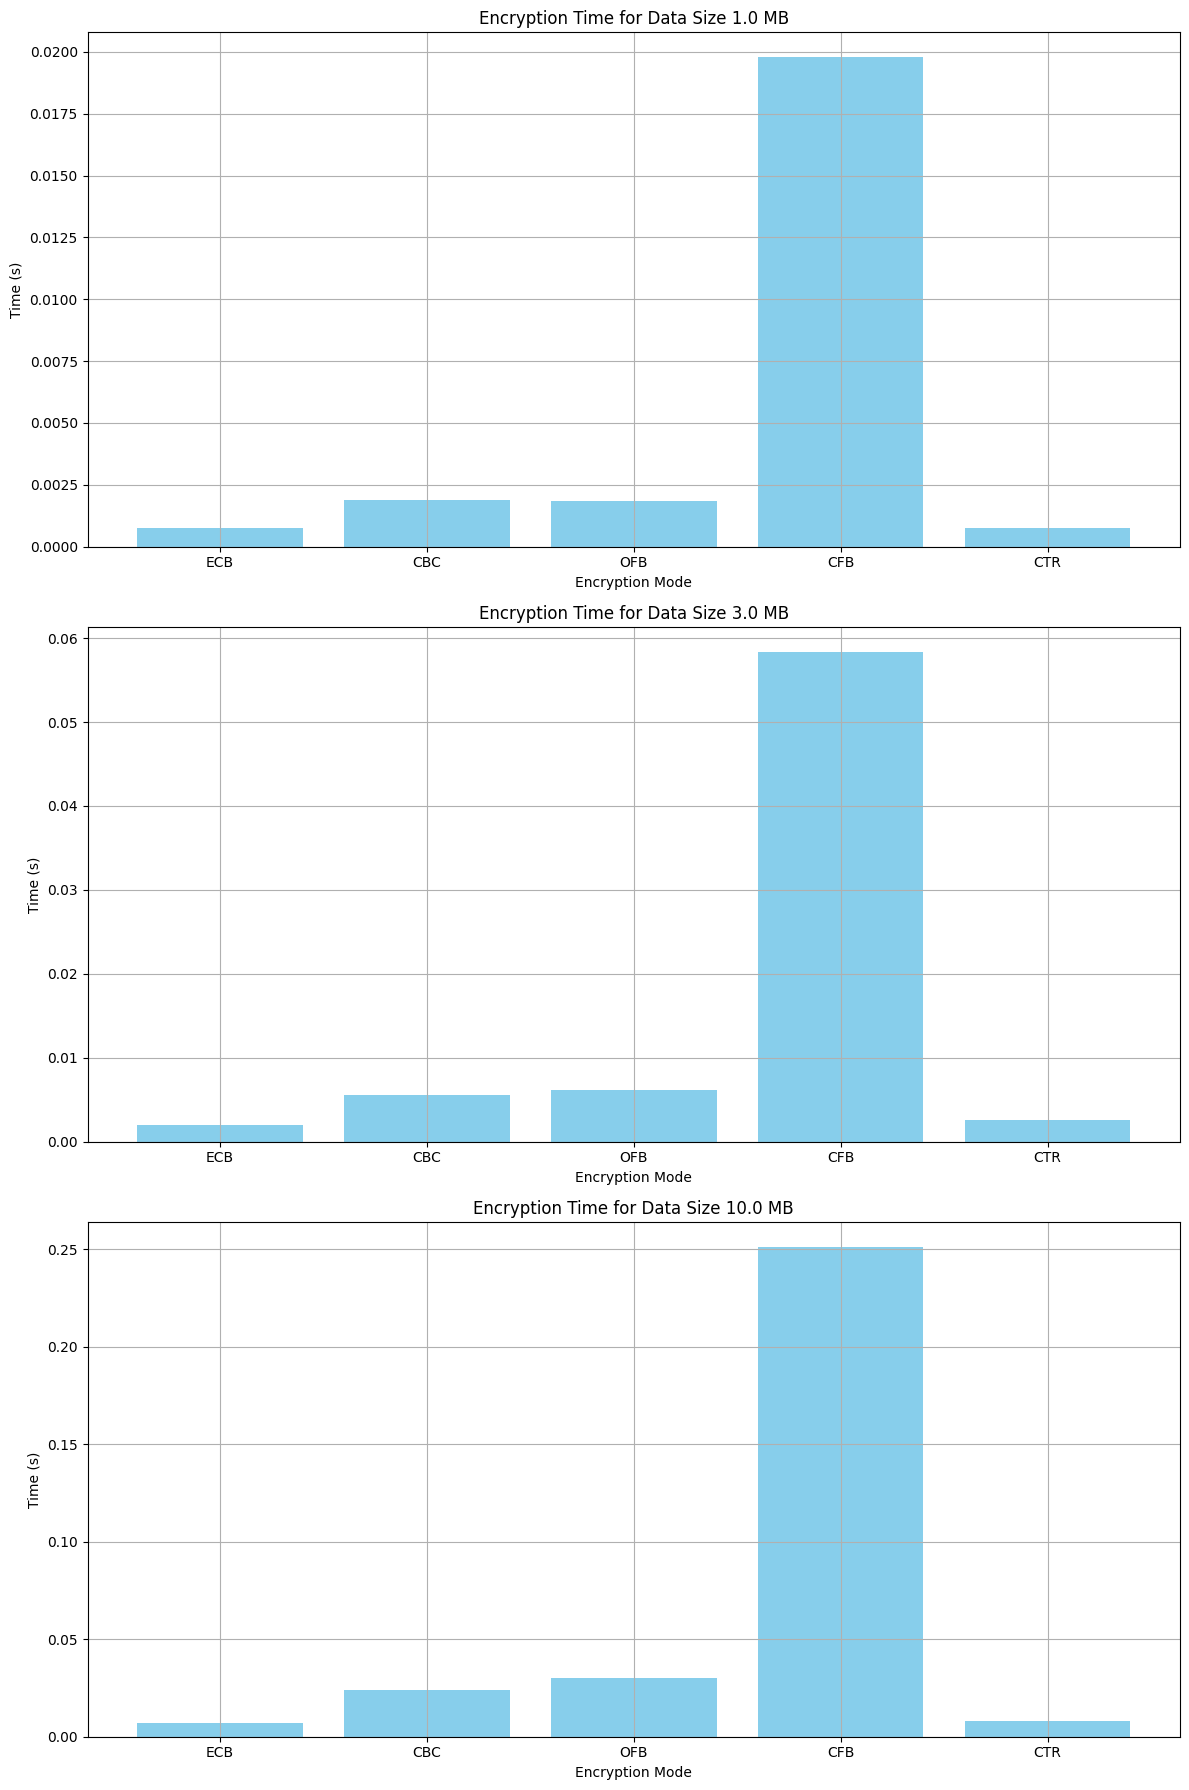

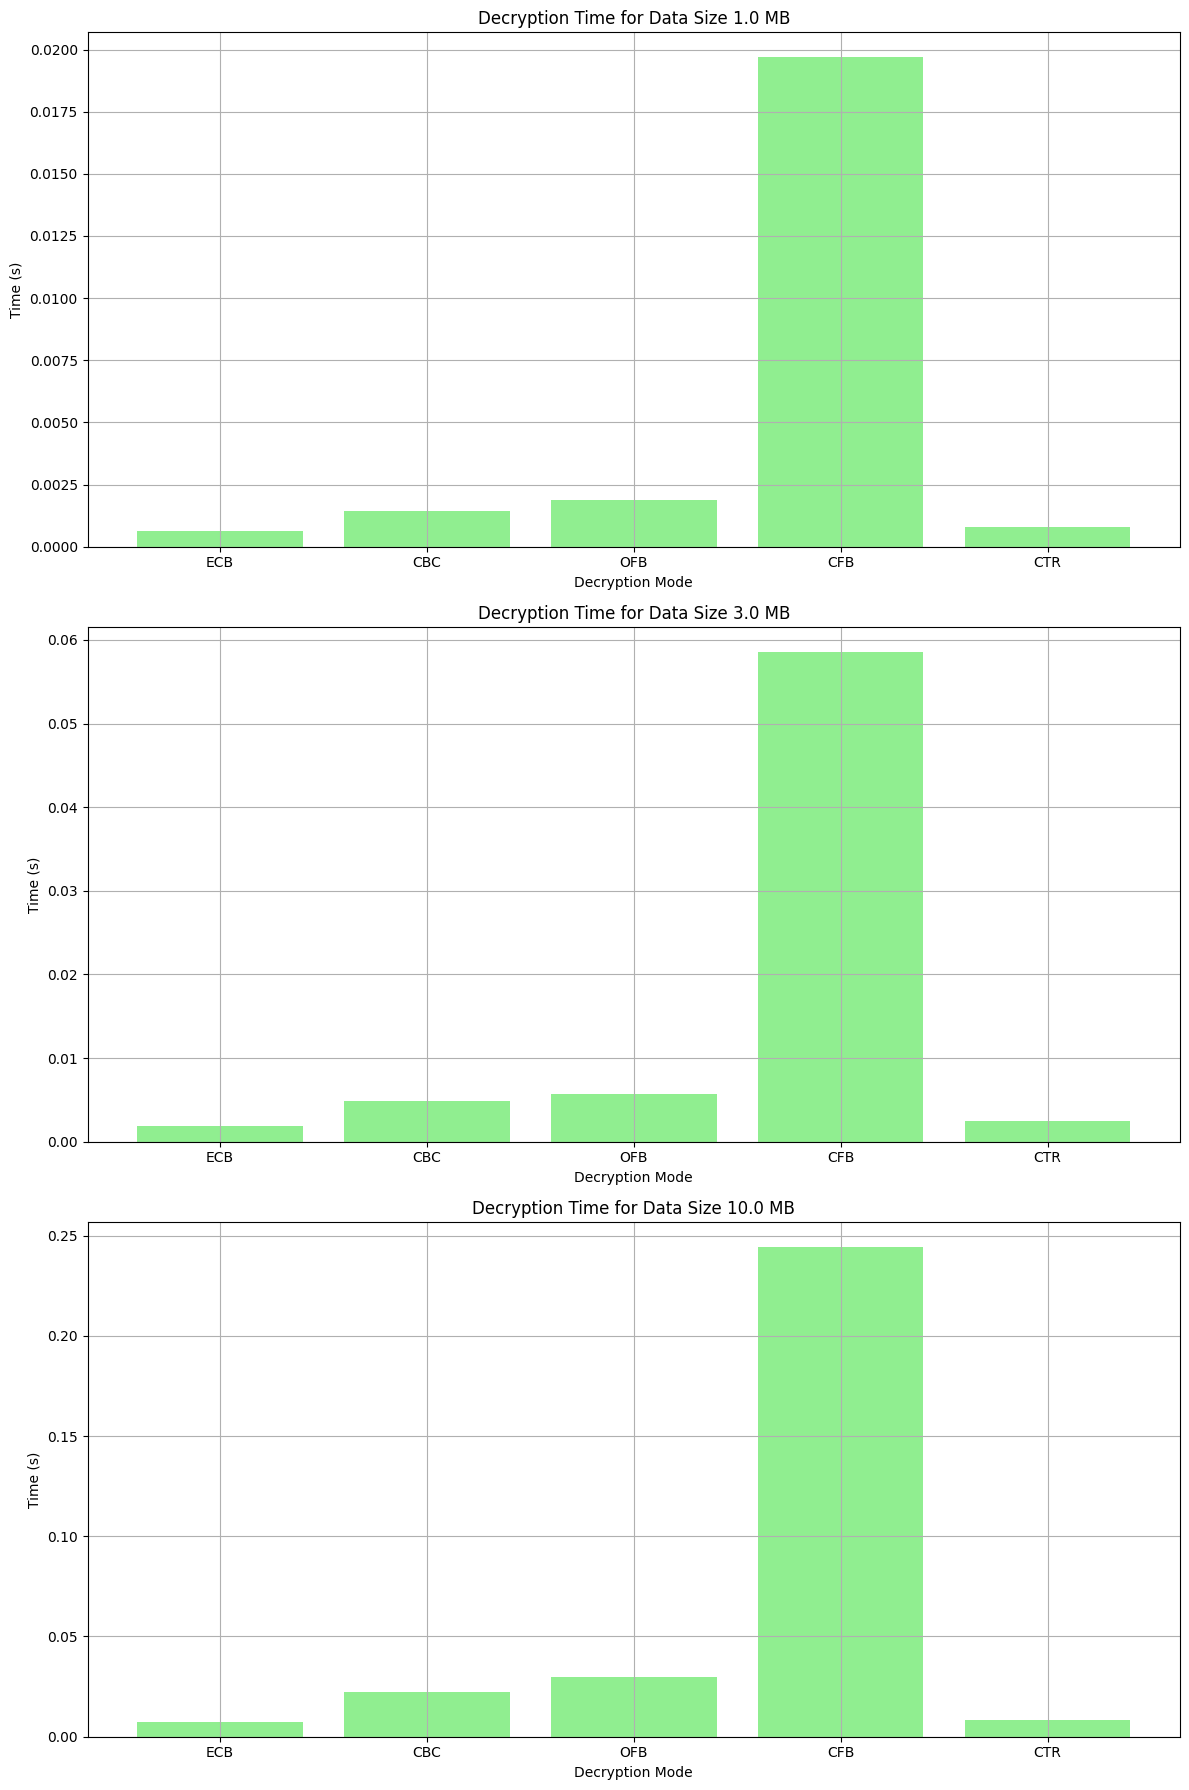

In [1]:
import matplotlib.pyplot as plt

data_sizes = [1.0, 3.0, 10.0]
modes = ['ECB', 'CBC', 'OFB', 'CFB', 'CTR']
encryption_times = [
    [0.000747, 0.001879, 0.001861, 0.019798, 0.000744],
    [0.001976, 0.005512, 0.006146, 0.058364, 0.002640],
    [0.006979, 0.023874, 0.029980, 0.251175, 0.008241]
]
decryption_times = [
    [0.000642, 0.001445, 0.001862, 0.019706, 0.000791],
    [0.001873, 0.004926, 0.005704, 0.058585, 0.002432],
    [0.007124, 0.022203, 0.029934, 0.244379, 0.008114]
]


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

for i, size in enumerate(data_sizes):
    axes[i].bar(modes, encryption_times[i], color='skyblue')
    axes[i].set_title(f'Encryption Time for Data Size {size} MB')
    axes[i].set_xlabel('Encryption Mode')
    axes[i].set_ylabel('Time (s)')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

for i, size in enumerate(data_sizes):
    axes[i].bar(modes, decryption_times[i], color='lightgreen')
    axes[i].set_title(f'Decryption Time for Data Size {size} MB')
    axes[i].set_xlabel('Decryption Mode')
    axes[i].set_ylabel('Time (s)')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

### Wnioski
CTR jest najbardziej efektywny pod względem szybkości, średnie czasy szyfrowania dla tego trybu są najniższe we wszystkich trzech przypadkach rozmiaru danych. Najwolniejszym trybem szyfrowania jest CFB. Średnie czasy szyfrowania dla tego trybu są znacznie wyższe niż dla innych trybów, szczególnie dla większych rozmiarów danych. Różnice w szybkości pomiędzy różnymi trybami wynikają głównie z różnych sposobów przetwarzania danych oraz dodatkowych operacji, takich jak synchronizacja i wykorzystanie wektorów inicjalizacyjnych. Na przykład tryby OFB i CTR są trybami strumieniowymi, które mogą być bardziej efektywne dla dużych ilości danych, podczas gdy tryby CBC i CFB wymagają większej ilości operacji, co prowadzi do dłuższych czasów wykonania.

## Analiza propagacji błędów

In [5]:
from random import getrandbits
from Crypto.Cipher import AES


def padding(x):
    padding_length = AES.block_size - len(x) % AES.block_size
    return x + b'\0' * padding_length

def strip(x):
    return x.rstrip(b'\0')

def hex_rep(x):
    hex_list = []
    for b in x:
        hex_list.append(f'{b:02X}')
    return ' '.join(hex_list)

def cipher_params(cipher, mode):
    if mode in [AES.MODE_CBC, AES.MODE_OFB, AES.MODE_CFB]: return dict(iv=cipher.iv)
    if mode in [AES.MODE_CTR]: return dict(nonce=cipher.nonce)
    return {}
modenames = 'ECB CBC OFB CTR CFB'.split()
modes = [AES.MODE_ECB, AES.MODE_CBC, AES.MODE_OFB, AES.MODE_CTR, AES.MODE_CFB]
key = getrandbits(16*8).to_bytes(16, byteorder='little')

with open('test_prop.txt', 'rb') as f:
    test = f.read()

print('oryginalny tekst:')
print(test,"\n")

for mode, name in zip(modes, modenames):
    c1 = AES.new(key, mode)
    encrypted = c1.encrypt(padding(test))

    encrypted = bytearray(encrypted)
    encrypted[1] = 2

    c2 = AES.new(key, mode, **cipher_params(c1, mode))
    decrypted = strip(c2.decrypt(encrypted))
    print(name)
    print(decrypted)
    print()

oryginalny tekst:
b'Foxes are small to medium-sized, omnivorous mammals belonging to several genera of the family Canidae. They have a flattened skull, upright, triangular ears, a pointed, slightly upturned snout, and a long bushy tail ("brush").' 

ECB
b'\x01C$G\x16\xd2\x1d\x0e>n\xa6\xf9}\xa6Jmto medium-sized, omnivorous mammals belonging to several genera of the family Canidae. They have a flattened skull, upright, triangular ears, a pointed, slightly upturned snout, and a long bushy tail ("brush").'

CBC
b'4S\xd2>7\xcd\xbd\xcb+$9\x9ei\x1b\x03\xd4t\xd2 medium-sized, omnivorous mammals belonging to several genera of the family Canidae. They have a flattened skull, upright, triangular ears, a pointed, slightly upturned snout, and a long bushy tail ("brush").'

OFB
b'F\xa8xes are small to medium-sized, omnivorous mammals belonging to several genera of the family Canidae. They have a flattened skull, upright, triangular ears, a pointed, slightly upturned snout, and a long bushy tail ("br

### Wnioski
W trybach OFB i CTR, błąd w szyfrogramie nie uniemożliwia odczytu całej wiadomości, ponieważ wpływa tylko na część tekstu. W trybach CBC i CFB, błąd w szyfrogramie może uniemożliwić odczytanie całej wiadomości lub jej fragmentu, ponieważ wpływa na kolejne bloki.

## Implementacja trybu CBC

In [6]:
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad, unpad

def encrypt_cbc(data, key, iv):
    cipher = AES.new(key, AES.MODE_ECB)
    encrypted_data = b''
    previous_block = iv

    # Podział danych na bloki
    for i in range(0, len(data), AES.block_size):
        block = data[i:i+AES.block_size]

        # Wykonanie operacji XOR z poprzednim blokiem lub IV
        block_xor = bytes([b1 ^ b2 for b1, b2 in zip(block, previous_block)])

        # Szyfrowanie wyniku operacji XOR za pomocą trybu ECB
        encrypted_block = cipher.encrypt(block_xor)

        # Dodanie zaszyfrowanego bloku do zaszyfrowanych danych
        encrypted_data += encrypted_block
        previous_block = encrypted_block  # Ustawienie poprzedniego bloku na bieżący zaszyfrowany blok

    return encrypted_data

def decrypt_cbc(data, key, iv):
    cipher = AES.new(key, AES.MODE_ECB)
    decrypted_data = b''
    previous_block = iv

    for i in range(0, len(data), AES.block_size):
        block = data[i:i+AES.block_size]

        # Deszyfrowanie bloku za pomocą trybu ECB
        decrypted_block = cipher.decrypt(block)

        # Wykonanie operacji XOR z poprzednim blokiem lub IV
        decrypted_block_xor = bytes([b1 ^ b2 for b1, b2 in zip(decrypted_block, previous_block)])

        # Dodanie zdeszyfrowanego bloku do zdeszyfrowanych danych
        decrypted_data += decrypted_block_xor
        previous_block = block

    return decrypted_data


plaintext = b'Testowanie dzialania trybu cbc'
key = get_random_bytes(16)
iv = get_random_bytes(AES.block_size)

encrypted_data = encrypt_cbc(pad(plaintext, AES.block_size), key, iv)
decrypted_data = unpad(decrypt_cbc(encrypted_data, key, iv), AES.block_size)

print('--- Original ---')
print(plaintext)
print('--- Encrypted ---')
print(encrypted_data)
print('--- Decrypted ---')
print(decrypted_data)


--- Original ---
b'Testowanie dzialania trybu cbc'
--- Encrypted ---
b'\x86\n\x12\x02\x81=\xc5\xe73;\xd4A\x93\xf7i\x9b\x8a8\xf5\x9b\xc9\x13\x10\xd7\xe5\xa0=\xbd\x01z\xf6W'
--- Decrypted ---
b'Testowanie dzialania trybu cbc'
